# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: *insert your name here*

**Matricola**: *insert your ID here*

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

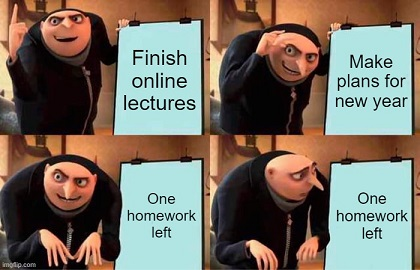

In [ ]:
import tensorflow as tf

In [ ]:
## Install Tensorflow Addons
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
## Import utils
import os
import glob
import matplotlib.pyplot as plt
import timeit
from tqdm import *
from tensorflow import keras
from tensorflow import image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow_addons as tfa
import shutil
from pathlib import Path
import warnings

from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.utils import image_dataset_from_directory
from keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow_addons.metrics import F1Score

from image import random_flip_left_right, random_flip_up_down,random_brightness,random_contrast

from keras.losses import CategoricalCrossentropy
from tensorflow.math import reduce_max
from keras.optimizers import Adam

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

### **Task description**
**Scene Classification** is a task in which scenes from photographs are categorically classified. Unlike object classification, which focuses on classifying prominent objects in the foreground, Scene Classification uses the layout of objects within the scene, in addition to the ambient context, for classification[1].

### **Dataset**

The dataset used is [**intel-image-classification**](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), it's composed by 6 classes representing different environments:

0 - buildings;

1 - forest;

2 - glacier;

3 - mountain;

4 - sea;

5 - street.

### **References**

[1] [**Scene classification with Convolutional Neural Networks**](http://cs231n.stanford.edu/reports/2017/pdfs/102.pdf)


The first part of this work concerns the import of data from kaggle and some **exploratory analysis** and **data-wrangling** operations

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

## Install kaggle
!pip install kaggle

In [ ]:
## Create an API Token from our kaggle account
## Upload kaggle.json to your Colab runtime

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

## Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!kaggle datasets download "puneet6060/intel-image-classification"

!unzip intel-image-classification.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg

In [ ]:
## Save the data paths

path_train = "/content/seg_train/seg_train"
path_test = "/content/seg_test/seg_test"
labels    = ["buildings","forest","glacier","mountain","sea","street"]

In [ ]:
## Check the number of images for each class
for label in labels:
    dir = os.path.join(path_train, label)
    print("Number of " + label + " images" ":\t", len(os.listdir(dir)))

Number of buildings images:	 2191
Number of forest images:	 2271
Number of glacier images:	 2404
Number of mountain images:	 2512
Number of sea images:	 2274
Number of street images:	 2382


While there is minimal difference between the number of images in each class, we can assume the dataset is balanced.

With the following function it is possible to randomly display images within the dataset.

In [ ]:
## This function is used to visualize random for each class
import random
def image_plot(path, labels, num_images):
    """Input:
       Output: """

    ## Set Figsize
    plt.figure(figsize = (15, 10))

    for label in range(len(labels)):
        ## Save the path for each class
        dir = os.path.join(path, labels[label])
        size = len(os.listdir(dir))
        idx = idx = random.sample(range(0, int(size)), k=num_images)
        c = 0
        for i in idx:
            img_path = os.path.join(dir, os.listdir(dir)[i])
            img = plt.imread(img_path)

            plt.subplot(len(labels), num_images, label*num_images + c + 1)
            plt.imshow(img)

            ## Set the name of classes along y axis
            if c == 0:
                plt.ylabel(labels[label], fontsize = 20)
            c = c+1

    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = []);
    plt.tight_layout()

In [ ]:
## Plot random images
image_plot(path_train, labels, 5)

For each class, 5 images are shown.

At this point, the data present in the directory is loaded and the training, validation and test set are obtained.

In [ ]:
## Import Datasets



## Set the batch size and img dimention
batch_size = 32
img_dim  = 150

print("-----------------")
print("Training Set:")
print("-----------------")

X_train = image_dataset_from_directory(
    path_train,
    image_size = (img_dim, img_dim),
    subset = "training",
    validation_split = 0.3,
    seed = 123,
    label_mode = "categorical"
)

print("-----------------")
print("Validation Set")
print("-----------------")


## Validation Data
X_val = image_dataset_from_directory(
    path_train,
    image_size = (img_dim, img_dim),
    subset = "validation",
    validation_split = 0.3,
    seed = 123       ,
    label_mode = "categorical"

)

print("-----------------")
print("Test Set")
print("-----------------")

X_test = image_dataset_from_directory(
    path_test,                            ## Path test
    image_size = (img_dim, img_dim), ## Image Size
    validation_split = 0,                 ## Testing
    seed = 123,                           ## Set seed
    label_mode = "categorical"
)


n_classes = 6

-----------------
Training Set:
-----------------
Found 14034 files belonging to 6 classes.
Using 9824 files for training.
-----------------
Validation Set
-----------------
Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
-----------------
Test Set
-----------------
Found 3000 files belonging to 6 classes.


The images in the directory used for model training have been split into the training (70%) and validation set (30%).

**Data Agumentation**

In the following steps, data augmentation is performed, in order to increase the number of the training data, and avoid possible overfitting situation.

In [ ]:


## Function to apply data augmentation to a single batch
def augment_data(batch_x, batch_y):
    ## Apply data augmentation transformations
    augmented_batch_x = random_flip_left_right(batch_x)
    augmented_batch_x = random_flip_up_down(batch_x)
    augmented_batch_x = random_brightness(augmented_batch_x, max_delta=0.2)
    augmented_batch_x = random_contrast(augmented_batch_x, lower=0.5, upper=1.5)

    return augmented_batch_x, batch_y

augmented_train_data = X_train.map(augment_data)

In [ ]:
X_train_aug = X_train.concatenate(augmented_train_data)

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

The following architecture consists of three layers composed by:

- 2D Convolution;
- ReLU Activation Function;
- BatchNormalizzation;
- Max Pooling;
- Dropout.

After these three layers, we also have an additional final layer.
In the last layer we find a Dense layer with 256 neurons, followed by dropouts, and finally we have the output neurons.

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).

model = Sequential([

    ## Layer 1
    Conv2D(32, (7, 7), input_shape=(150, 150, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.1),

    ## Layer 2
    Conv2D(64, (5, 5), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    ## Layer 3
    Conv2D(128, (3, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),


    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax') ## N of output neurons equal to the number of classes


])

Before compiling the model, some parameters useful for training have been set.

In [ ]:
# You can train using fit() or a custom training loop, equivalently.
## Training set up

## Choose the number of epochs
num_epochs = 50

In [ ]:
## Metrics

metrics = ["accuracy",
           Precision(name = "Precision"),
           Recall(name = "Recall"),
           F1Score(num_classes = 6, threshold = 0.5)]

## Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = metrics)






**Model Checkpoint** and **Early Stopping** are also used.

**Model checkpoint** save the model with the best validation loss.

Instead **Early Stopping** is a form of regularization that stops the training process of a neural network before it reaches the maximum number of epochs or iterations [[**Early Stopping in Neural Networks: Pros and Cons**](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.)]



In [ ]:
## Best model
checkpoint  = ModelCheckpoint("model.h5", monitor = "val_loss", save_best_only = True, mode = "min", verbose = 1)

## the early stopping
early_stop  = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)
reduce_lr   = ReduceLROnPlateau(monitor = "val_loss", factor = tf.math.sqrt(0.1), patience = 5, min_delta = 0.05,verbose = 1)

In [ ]:
## Train the model
start = timeit.default_timer()

model_history = model.fit(X_train_aug, epochs = num_epochs, verbose = 1,
                          batch_size = batch_size, callbacks = [checkpoint, early_stop, reduce_lr], validation_data = X_val)

stop = timeit.default_timer()
print("Computational Time:", stop - start)

Epoch 1/50
614/614 [==============================] - ETA: 0s - loss: 2.8479 - accuracy: 0.4436 - Precision: 0.5815 - Recall: 0.2597 - f1_score: 0.3352
Epoch 1: val_loss improved from inf to 13.35637, saving model to model.h5
614/614 [==============================] - 62s 72ms/step - loss: 2.8479 - accuracy: 0.4436 - Precision: 0.5815 - Recall: 0.2597 - f1_score: 0.3352 - val_loss: 13.3564 - val_accuracy: 0.2494 - val_Precision: 0.2479 - val_Recall: 0.2368 - val_f1_score: 0.1430 - lr: 0.0010
Epoch 2/50
614/614 [==============================] - ETA: 0s - loss: 1.1876 - accuracy: 0.5159 - Precision: 0.6970 - Recall: 0.3237 - f1_score: 0.4211
Epoch 2: val_loss improved from 13.35637 to 2.33801, saving model to model.h5
614/614 [==============================] - 45s 73ms/step - loss: 1.1876 - accuracy: 0.5159 - Precision: 0.6970 - Recall: 0.3237 - f1_score: 0.4211 - val_loss: 2.3380 - val_accuracy: 0.4259 - val_Precision: 0.4879 - val_Recall: 0.3734 - val_f1_score: 0.3480 - lr: 0.0010
Epo

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

Several measures have been considered. In particular, the trend of the accuracy and of the Loss obtained on the training set and on the validation set are shown below.

- $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$


In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.

## Training Metrics
train_loss = model_history.history["loss"]
train_accuracy = model_history.history["accuracy"]
val_loss = model_history.history["val_loss"]
val_accuracy = model_history.history["val_accuracy"]

learning_rate = model_history.history['lr']
learning_rate = model_history.history['lr']

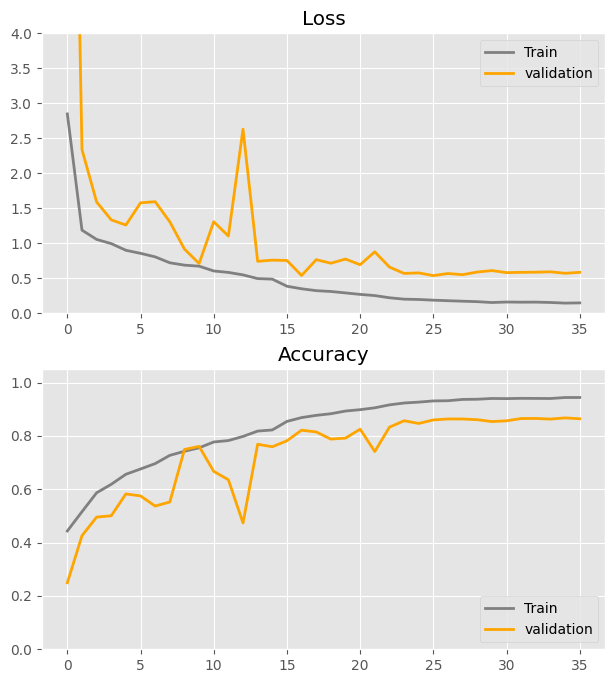

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize = (16, 8))
#plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

## Loss Plot
plt.subplot(221)
## Train
plt.plot(train_loss, color = "grey", label = "Train", linewidth = 2)
## Validation
plt.plot(val_loss, color = "orange", label = "validation", linewidth = 2)
plt.ylim(0, 4)
plt.title("Loss")
plt.xlabel("")
plt.legend()

## Accuracy Plot
plt.subplot(223)
## Train
plt.plot(train_accuracy, color = "grey", label = "Train", linewidth = 2)
## Validation
plt.plot(val_accuracy, color = "orange", label = "validation", linewidth = 2)
plt.ylim(0, 1.05)
plt.title("Accuracy")
plt.xlabel("")
plt.legend(loc = "lower right")

plt.show()

Training loss shows reduced variability and converges to zero more rapidly. However, the validation loss also exhibits a declining trend.

Additionally, the metrics exhibit reduced variability after the initial 22/23 training epochs. This suggests that performance tends to stabilize around specific values, indicating a greater level of consistency.

Although the number of epochs chosen for the training was 50, it ended at the 36th epoch due to the **Early Stopping** which, due to an increase in the accuracy calculated on the validation test, stopped the training.

In [ ]:
## Plottare il learning rate

## **Prediction Step**

Best model used to make the forecasts.

In [ ]:
## Show random test images

image_plot(path_train, labels, 5)

In [ ]:
## Check the number of images for each class into the test set
for label in labels:
    dir = os.path.join(path_test, label)
    print("Number of " + label + " images" ":\t", len(os.listdir(dir)))

Number of buildings images:	 437
Number of forest images:	 474
Number of glacier images:	 553
Number of mountain images:	 525
Number of sea images:	 510
Number of street images:	 501


In [ ]:
## Load model
best_model = load_model("model.h5")

In [ ]:
## Evaluate on Test Set
best_model.evaluate(X_test)

94/94 [==============================] - 3s 28ms/step - loss: 0.5408 - accuracy: 0.8587 - Precision: 0.8717 - Recall: 0.8450 - f1_score: 0.8585


[0.5407975912094116,
 0.8586666584014893,
 0.8717331290245056,
 0.8450000286102295,
 array([0.81602   , 0.9716088 , 0.8157389 , 0.81261593, 0.8682927 ,
        0.8667325 ], dtype=float32)]

In [ ]:
## Prediction
y_soft = best_model.predict(X_test)
y_pred = tf.argmax(y_soft, axis = 1)


res = []
## Save Y test
for step, (X_batch_test, Y_batch_test) in enumerate(X_test):
  res.append(tf.argmax(Y_batch_test, axis = 1))
  #print(tf.argmax(Y_batch_test, axis = 1))


y_test = tf.concat((res),axis = 0)

94/94 [==============================] - 2s 20ms/step


In [ ]:
y_test

<tf.Tensor: shape=(3000,), dtype=int64, numpy=array([0, 3, 5, ..., 3, 0, 2])>

---------------
Classes names
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
---------------


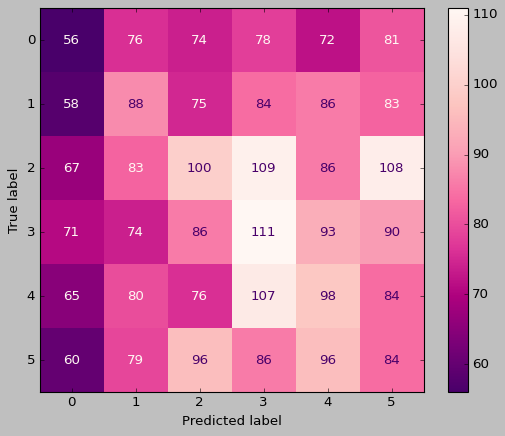

In [ ]:
## Confusion Matrix
plt.style.use("classic")

print("---------------")
print("Classes names")
print(X_test.class_names)
print("---------------")



## Confusion Matrix Plot
cm_cnn      = confusion_matrix(y_test, y_pred)
cm_cnn_plot = ConfusionMatrixDisplay(cm_cnn)
cm_cnn_plot.plot(values_format = "g", cmap = "RdPu_r")

In [ ]:
## Prediction
y_soft_2 = best_model.predict(X_test)
y_pred_2 = tf.argmax(y_soft_2, axis = 1)


res_2 = []
## Save Y test
for step, (X_batch_test, Y_batch_test) in enumerate(X_test):
  res_2.append(tf.argmax(Y_batch_test, axis = 1))
  #print(tf.argmax(Y_batch_test, axis = 1))


y_test_2 = tf.concat((res),axis = 0)

94/94 [==============================] - 2s 19ms/step


---------------
Classes names
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
---------------


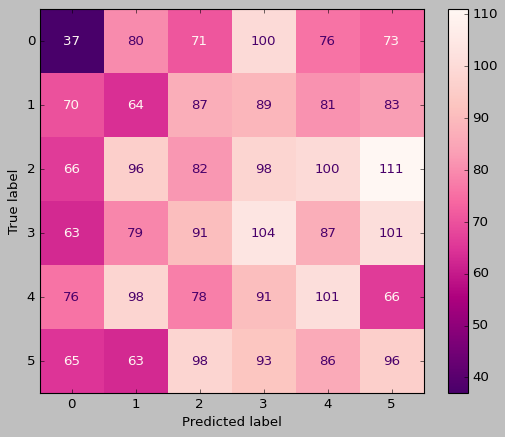

In [ ]:
## Confusion Matrix
plt.style.use("classic")

print("---------------")
print("Classes names")
print(X_test.class_names)
print("---------------")



## Confusion Matrix Plot
cm_cnn      = confusion_matrix(y_test_2, y_pred_2)
cm_cnn_plot = ConfusionMatrixDisplay(cm_cnn)
cm_cnn_plot.plot(values_format = "g", cmap = "RdPu_r")

### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

#### **Modula Neural Netwok (Early Exit variant)**

Early exits allow to obtain predictions at intermediate points of the stack . These multi-output networks have a number of advantages, including:
1. significant reductions of the inference time;
2. reduced tendency to overfitting and vanishing gradients;
3. capability of being distributed over multi-tier computation platforms.

**References**

[**Why should we add early exits to neural networks?**](https://arxiv.org/pdf/2004.12814.pdf)


The constructor of the "EarlyExit" class takes as arguments:
1. the threshold value ("threshold"): represents the confidence threshold above which a preliminary prediction is accepted as the final output;
2. a list of exit indexes ("exits"): a list of indices specifying the exit points in the model, i.e. the points where the preliminary predictions are made.

The first part of the model is represented by the backbone model, defined in the previous points of this work.

Furthermore, the class defines, also, a list of self.classifiers, one for each exit point specified in the "exits" list. Each classifier consists of a flatten followed by a dense layer with softmax activation.

The "call" method takes as arguments:
1. "inputs" (the input data);
2. "training" (a boolean flag indicating whether the model is running in training mode);
3. "labels" (the input data labels).
The method iterates through the layers of the model, performing data forwarding. When it reaches an exit point specified in the "exits" list, it calculates the output of the corresponding classifier. If the model is run in inference mode (Training == False), it is checked if the output exceeds the specified confidence threshold. If so, the output is returned as the final output of the model. Finally, the method returns a list containing the intermediate outputs of the classifiers, as well as the output of the last layer of the model when it reaches index 18.



In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

## This class represents a convolutional neural network model with the ability to perform "early exits",
## i.e. to provide a preliminary prediction before completing the entire model run.

## Define the Erly exit class

class EarlyExit(tf.keras.Model):
    def __init__(self, threshold, exits, num_classes = 6):

## The constructor of the "EarlyExit" class takes as arguments:
## 1. the threshold value ("threshold"): represents the confidence threshold above which a preliminary prediction is accepted as the final output;
## 2. a list of exit indexes ("exits"): a list of indices specifying the exit points in the model, i.e. the points where the preliminary predictions are made.

## The first part of the model is represented by the backbone model, defined in the previous points of this work.

## Furthermore, the class defines, also, a list of self.classifiers, one for each exit point specified in the "exits" list.
## Each classifier consists of a flatten followed by a dense layer with softmax activation.

        super(EarlyExit, self).__init__()
        self.threshold = threshold
        self.exits = exits
        #self.loss_fn = CategoricalCrossentropy()
        self.model_layers = Sequential([
            ## Layer 1
            Conv2D(32, (7, 7), input_shape=(150, 150, 3), padding='same'),
            ReLU(),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.1),

            ## Layer 2
            Conv2D(64, (5, 5), padding='same'),
            ReLU(),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            ## Layer 3
            Conv2D(128, (3, 3), padding='same'),
            ReLU(),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),


            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(6, activation='softmax')
        ])


        self.classifiers = [Sequential([
            Flatten(),
            Dense(num_classes, activation = "softmax")
        ]) for _ in exits]


    def call(self, inputs, training = None, labels = None):

## The "call" method takes as arguments:
## 1. "inputs": the input data;
## 2. "training": boolean, indicating whether the model is running in training mode;
## 3. "labels": the input data labels.
## The method iterates through the layers of the model, performing data forwarding.
## When it reaches an exit point specified in the "exits" list, it calculates the output of the corresponding classifier.
## If the model is run in inference mode (Training == False), it is checked if the output exceeds the specified confidence threshold.
## If so, the output is returned as the final output of the model. Finally, the method returns a list containing the intermediate outputs of the classifiers,
## as well as the output of the last layer of the model when it reaches index 18.

      x = inputs
      res = []
      c = 0
      for i, layer in enumerate(self.model_layers.layers):
        x = layer(x)
        if i in self.exits:
          output = self.classifiers[c](x)
          res.append(output)

          if training == False:
            if reduce_max(output, axis = 1) > self.threshold:
              return output
          c = c+1

        if i == 18:
          res.append(x)

      return res

In [ ]:
ee_mod = EarlyExit(exits = [5,10,15], threshold = 0.5)

In [ ]:
@tf.function
def train_step(inputs, targets, model, optimizer, loss_fn, loss_metric, final_acc, ee1_acc, ee2_acc, ee3_acc):
    with tf.GradientTape() as tape:

        outputs = model(inputs, training=True) ## Prediction

        loss = loss_fn(targets, outputs) ## Loss Function

    ## Gradients
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    final_loss = loss_metric(loss) ## Cross-Entropy Loss

    ## Accuracies
    final_acc.update_state(targets, outputs[-1])
    ee1_acc.update_state(targets, outputs[0])
    ee2_acc.update_state(targets, outputs[1])
    ee3_acc.update_state(targets, outputs[2])

In [ ]:
start = timeit.default_timer()

In [ ]:
# Initialize metrics and lists

epochs = 35
optimizer = Adam()
cce = CategoricalCrossentropy()

loss_metric = Mean()
Accuracy = CategoricalAccuracy()

ee1_acc = CategoricalAccuracy()
ee2_acc = CategoricalAccuracy()
ee3_acc = CategoricalAccuracy()


losses = []
Accuracies = []
ee1_accs = []
ee2_accs = []
ee3_accs = []



In [ ]:
## Loss function = sum of the partial ones
def Summed_Loss(y_true, y_pred):
  loss_1 = cce(y_true, y_pred[0])
  loss_2 = cce(y_true, y_pred[1])
  loss_3 = cce(y_true, y_pred[2])
  model_loss = cce(y_true, y_pred[-1])
  final_loss = loss_1 + loss_2 + loss_3 + model_loss
  return final_loss

In [ ]:
# Define the custom training loop

# Start the custom training loop
for epoch in tqdm(range(epochs)):
    print("\nStart of epoch %d" % (epoch))

    for step, (inputs, targets) in enumerate(X_train_aug):
        train_step(inputs, targets, ee_mod, optimizer, Summed_Loss, loss_metric, Accuracy, ee1_acc, ee2_acc, ee3_acc)


    print("Loss:", float(loss_metric.result()))
    losses.append(loss_metric.result())

    ## Print the final accuracies
    print("Accuracy over epoch: %.4f" % (float(Accuracy.result()),))
    print("Early Exit 1 over epoch acc: %.4f" % (float(ee1_acc.result()),))
    print("Early Exit 2 over epoch acc: %.4f" % (float(ee2_acc.result()),))
    print("Early Exit 3 over epoch acc: %.4f" % (float(ee3_acc.result()),))

    Accuracies.append(Accuracy.result())
    ee1_accs.append(ee1_acc.result())
    ee2_accs.append(ee2_acc.result())
    ee3_accs.append(ee3_acc.result())

    ## Reset metrics for the next epoch
    loss_metric.reset_states()
    Accuracy.reset_states()
    ee1_acc.reset_states()
    ee2_acc.reset_states()
    ee3_acc.reset_states()

stop = timeit.default_timer()
print("Computational Time:", stop - start)

  0%|          | 0/35 [00:00<?, ?it/s]


Start of epoch 0


  3%|▎         | 1/35 [00:39<22:06, 39.03s/it]

Loss: 46.00407791137695
Accuracy over epoch: 0.4261
Early Exit 1 over epoch acc: 0.4736
Early Exit 2 over epoch acc: 0.4762
Early Exit 3 over epoch acc: 0.4824

Start of epoch 1


  6%|▌         | 2/35 [01:14<20:24, 37.12s/it]

Loss: 30.288063049316406
Accuracy over epoch: 0.5062
Early Exit 1 over epoch acc: 0.5707
Early Exit 2 over epoch acc: 0.5512
Early Exit 3 over epoch acc: 0.5516

Start of epoch 2


  9%|▊         | 3/35 [01:50<19:23, 36.35s/it]

Loss: 21.839115142822266
Accuracy over epoch: 0.5707
Early Exit 1 over epoch acc: 0.6399
Early Exit 2 over epoch acc: 0.5972
Early Exit 3 over epoch acc: 0.5934

Start of epoch 3


 11%|█▏        | 4/35 [02:25<18:39, 36.10s/it]

Loss: 14.5068998336792
Accuracy over epoch: 0.6129
Early Exit 1 over epoch acc: 0.6984
Early Exit 2 over epoch acc: 0.6515
Early Exit 3 over epoch acc: 0.6356

Start of epoch 4


 14%|█▍        | 5/35 [03:01<17:55, 35.86s/it]

Loss: 8.59567928314209
Accuracy over epoch: 0.6575
Early Exit 1 over epoch acc: 0.7518
Early Exit 2 over epoch acc: 0.6965
Early Exit 3 over epoch acc: 0.6757

Start of epoch 5


 17%|█▋        | 6/35 [03:37<17:17, 35.78s/it]

Loss: 5.867883682250977
Accuracy over epoch: 0.7015
Early Exit 1 over epoch acc: 0.7973
Early Exit 2 over epoch acc: 0.7496
Early Exit 3 over epoch acc: 0.7195

Start of epoch 6


 20%|██        | 7/35 [04:12<16:40, 35.74s/it]

Loss: 4.080593109130859
Accuracy over epoch: 0.7310
Early Exit 1 over epoch acc: 0.8240
Early Exit 2 over epoch acc: 0.7818
Early Exit 3 over epoch acc: 0.7457

Start of epoch 7


 23%|██▎       | 8/35 [04:48<16:03, 35.70s/it]

Loss: 3.065969944000244
Accuracy over epoch: 0.7587
Early Exit 1 over epoch acc: 0.8534
Early Exit 2 over epoch acc: 0.8086
Early Exit 3 over epoch acc: 0.7739

Start of epoch 8


 26%|██▌       | 9/35 [05:24<15:30, 35.80s/it]

Loss: 2.48685359954834
Accuracy over epoch: 0.7872
Early Exit 1 over epoch acc: 0.8694
Early Exit 2 over epoch acc: 0.8307
Early Exit 3 over epoch acc: 0.8007

Start of epoch 9


 29%|██▊       | 10/35 [06:00<14:54, 35.77s/it]

Loss: 2.179459810256958
Accuracy over epoch: 0.8100
Early Exit 1 over epoch acc: 0.8747
Early Exit 2 over epoch acc: 0.8388
Early Exit 3 over epoch acc: 0.8146

Start of epoch 10


 31%|███▏      | 11/35 [06:35<14:16, 35.70s/it]

Loss: 1.8603655099868774
Accuracy over epoch: 0.8290
Early Exit 1 over epoch acc: 0.8952
Early Exit 2 over epoch acc: 0.8452
Early Exit 3 over epoch acc: 0.8298

Start of epoch 11


 34%|███▍      | 12/35 [07:16<14:17, 37.30s/it]

Loss: 1.6722441911697388
Accuracy over epoch: 0.8503
Early Exit 1 over epoch acc: 0.9010
Early Exit 2 over epoch acc: 0.8507
Early Exit 3 over epoch acc: 0.8443

Start of epoch 12


 37%|███▋      | 13/35 [07:52<13:31, 36.88s/it]

Loss: 1.5665292739868164
Accuracy over epoch: 0.8645
Early Exit 1 over epoch acc: 0.9058
Early Exit 2 over epoch acc: 0.8541
Early Exit 3 over epoch acc: 0.8505

Start of epoch 13


 40%|████      | 14/35 [08:28<12:46, 36.50s/it]

Loss: 1.4672926664352417
Accuracy over epoch: 0.8764
Early Exit 1 over epoch acc: 0.9079
Early Exit 2 over epoch acc: 0.8623
Early Exit 3 over epoch acc: 0.8569

Start of epoch 14


 43%|████▎     | 15/35 [09:03<12:04, 36.22s/it]

Loss: 1.3566488027572632
Accuracy over epoch: 0.8906
Early Exit 1 over epoch acc: 0.9151
Early Exit 2 over epoch acc: 0.8664
Early Exit 3 over epoch acc: 0.8678

Start of epoch 15


 46%|████▌     | 16/35 [09:39<11:25, 36.06s/it]

Loss: 1.3560417890548706
Accuracy over epoch: 0.8956
Early Exit 1 over epoch acc: 0.9107
Early Exit 2 over epoch acc: 0.8659
Early Exit 3 over epoch acc: 0.8748

Start of epoch 16


 49%|████▊     | 17/35 [10:15<10:47, 35.96s/it]

Loss: 1.2433127164840698
Accuracy over epoch: 0.9081
Early Exit 1 over epoch acc: 0.9141
Early Exit 2 over epoch acc: 0.8774
Early Exit 3 over epoch acc: 0.8813

Start of epoch 17


 51%|█████▏    | 18/35 [10:50<10:09, 35.86s/it]

Loss: 1.200164794921875
Accuracy over epoch: 0.9126
Early Exit 1 over epoch acc: 0.9136
Early Exit 2 over epoch acc: 0.8776
Early Exit 3 over epoch acc: 0.8873

Start of epoch 18


 54%|█████▍    | 19/35 [11:26<09:32, 35.79s/it]

Loss: 1.1993449926376343
Accuracy over epoch: 0.9165
Early Exit 1 over epoch acc: 0.9146
Early Exit 2 over epoch acc: 0.8793
Early Exit 3 over epoch acc: 0.8882

Start of epoch 19


 57%|█████▋    | 20/35 [12:02<08:56, 35.79s/it]

Loss: 1.1337289810180664
Accuracy over epoch: 0.9220
Early Exit 1 over epoch acc: 0.9194
Early Exit 2 over epoch acc: 0.8858
Early Exit 3 over epoch acc: 0.8966

Start of epoch 20


 60%|██████    | 21/35 [12:43<08:42, 37.34s/it]

Loss: 1.0531822443008423
Accuracy over epoch: 0.9298
Early Exit 1 over epoch acc: 0.9248
Early Exit 2 over epoch acc: 0.8971
Early Exit 3 over epoch acc: 0.9044

Start of epoch 21


 63%|██████▎   | 22/35 [13:18<07:59, 36.91s/it]

Loss: 1.0603171586990356
Accuracy over epoch: 0.9326
Early Exit 1 over epoch acc: 0.9237
Early Exit 2 over epoch acc: 0.8942
Early Exit 3 over epoch acc: 0.8996

Start of epoch 22


 66%|██████▌   | 23/35 [13:55<07:19, 36.65s/it]

Loss: 1.059073805809021
Accuracy over epoch: 0.9373
Early Exit 1 over epoch acc: 0.9258
Early Exit 2 over epoch acc: 0.8960
Early Exit 3 over epoch acc: 0.9062

Start of epoch 23


 69%|██████▊   | 24/35 [14:31<06:41, 36.54s/it]

Loss: 1.0623034238815308
Accuracy over epoch: 0.9374
Early Exit 1 over epoch acc: 0.9253
Early Exit 2 over epoch acc: 0.8997
Early Exit 3 over epoch acc: 0.9039

Start of epoch 24


 71%|███████▏  | 25/35 [15:07<06:04, 36.40s/it]

Loss: 0.957995593547821
Accuracy over epoch: 0.9424
Early Exit 1 over epoch acc: 0.9352
Early Exit 2 over epoch acc: 0.9076
Early Exit 3 over epoch acc: 0.9099

Start of epoch 25


 74%|███████▍  | 26/35 [15:43<05:26, 36.25s/it]

Loss: 0.9466399550437927
Accuracy over epoch: 0.9450
Early Exit 1 over epoch acc: 0.9337
Early Exit 2 over epoch acc: 0.9130
Early Exit 3 over epoch acc: 0.9163

Start of epoch 26


 77%|███████▋  | 27/35 [16:19<04:49, 36.16s/it]

Loss: 0.9059538841247559
Accuracy over epoch: 0.9481
Early Exit 1 over epoch acc: 0.9434
Early Exit 2 over epoch acc: 0.9143
Early Exit 3 over epoch acc: 0.9186

Start of epoch 27


 80%|████████  | 28/35 [16:55<04:12, 36.10s/it]

Loss: 0.9368633031845093
Accuracy over epoch: 0.9477
Early Exit 1 over epoch acc: 0.9353
Early Exit 2 over epoch acc: 0.9116
Early Exit 3 over epoch acc: 0.9169

Start of epoch 28


 83%|████████▎ | 29/35 [17:31<03:36, 36.10s/it]

Loss: 0.912772536277771
Accuracy over epoch: 0.9491
Early Exit 1 over epoch acc: 0.9424
Early Exit 2 over epoch acc: 0.9128
Early Exit 3 over epoch acc: 0.9187

Start of epoch 29


 86%|████████▌ | 30/35 [18:07<03:00, 36.11s/it]

Loss: 0.9173393249511719
Accuracy over epoch: 0.9518
Early Exit 1 over epoch acc: 0.9387
Early Exit 2 over epoch acc: 0.9154
Early Exit 3 over epoch acc: 0.9186

Start of epoch 30


 89%|████████▊ | 31/35 [18:43<02:24, 36.09s/it]

Loss: 0.8722169399261475
Accuracy over epoch: 0.9541
Early Exit 1 over epoch acc: 0.9445
Early Exit 2 over epoch acc: 0.9207
Early Exit 3 over epoch acc: 0.9246

Start of epoch 31


 91%|█████████▏| 32/35 [19:19<01:48, 36.06s/it]

Loss: 0.8388655185699463
Accuracy over epoch: 0.9588
Early Exit 1 over epoch acc: 0.9447
Early Exit 2 over epoch acc: 0.9209
Early Exit 3 over epoch acc: 0.9249

Start of epoch 32


 94%|█████████▍| 33/35 [19:55<01:12, 36.05s/it]

Loss: 0.8709523677825928
Accuracy over epoch: 0.9512
Early Exit 1 over epoch acc: 0.9458
Early Exit 2 over epoch acc: 0.9174
Early Exit 3 over epoch acc: 0.9262

Start of epoch 33


 97%|█████████▋| 34/35 [20:31<00:36, 36.15s/it]

Loss: 0.786500871181488
Accuracy over epoch: 0.9578
Early Exit 1 over epoch acc: 0.9515
Early Exit 2 over epoch acc: 0.9306
Early Exit 3 over epoch acc: 0.9309

Start of epoch 34


100%|██████████| 35/35 [21:08<00:00, 36.24s/it]

Loss: 0.8256756663322449
Accuracy over epoch: 0.9629
Early Exit 1 over epoch acc: 0.9495
Early Exit 2 over epoch acc: 0.9250
Early Exit 3 over epoch acc: 0.9262
Computational Time: 1296.303137022


In [ ]:
## Import test data with batch size 1
X_test_one_batch = image_dataset_from_directory(
    path_test,
    image_size = (img_dim, img_dim),
    validation_split = 0,
    seed = 123,
    label_mode = "categorical",
    batch_size = 1)

Found 3000 files belonging to 6 classes.


## Inference Step


In [ ]:
test_acc = tf.keras.metrics.CategoricalAccuracy()

for step, (inputs, targets) in enumerate(X_test_one_batch):
  output = ee_mod(inputs, training = False)
  test_acc.update_state(targets, output)

In [ ]:
print("Test Accuracy: %.4f" % (float(test_acc.result()),))
test_acc.reset_states()

Test Accuracy: 0.5062


✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

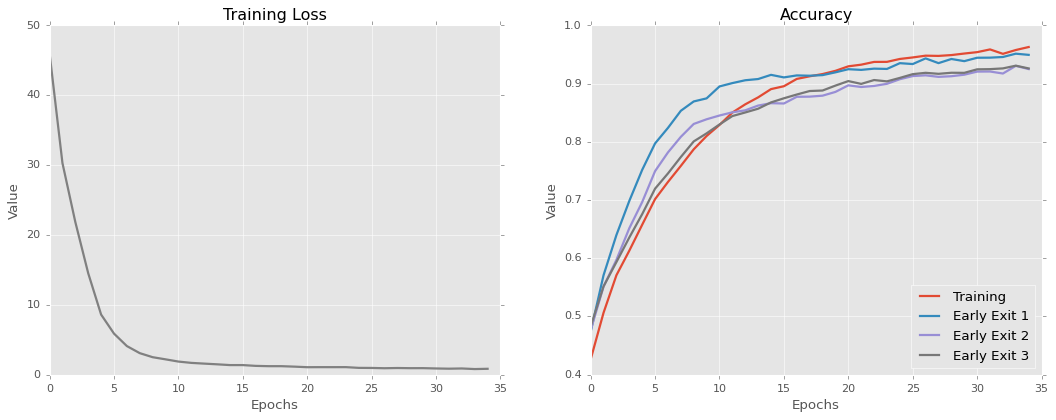

In [ ]:
# TODO: Add results here (anything appropriate is okay).

## Plot the average accuracy of each eatly exit
plt.style.use("ggplot")
plt.figure(figsize = (16, 12))

## Loss Plot
plt.subplot(221)
## Training Loss
plt.plot(losses, color = "grey", label = "Train", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss")

## Accuracy Plot
plt.subplot(222)
## Train
plt.plot(Accuracies,label = "Training", linewidth = 2)
plt.plot(ee1_accs, label = "Early Exit 1", linewidth = 2)
plt.plot(ee2_accs, label = "Early Exit 2", linewidth = 2)
plt.plot(ee3_accs, label = "Early Exit 3", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
plt.legend(loc = "lower right")

plt.show()

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

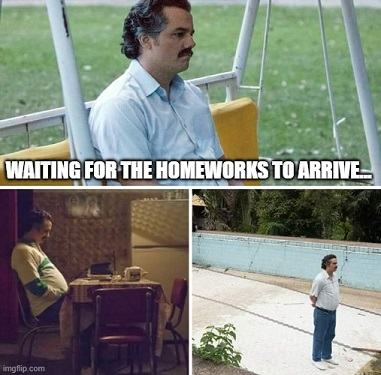